In [1]:
import matplotlib.pyplot as plt
import pylab
import math
import copy
import os
import time
import warnings
import numpy as np


from IPython.display import clear_output

import sys
sys.path.append("C:\\Users\\artur\\Desktop\\QAE")

from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

from qae_utils.Files import create_folder_if_needed, read_json_file, read_ts_file
from qae_utils.Charts import multi_plot_flat_ts, meas_plot
from qae_utils.Tools import draw_circuit
from qae_utils.Window import ts_wind_make, ts_wind_split, ts_wind_flatten_avg
from qae_utils.Window import ts_calc_noise, ts_add_noise
from qae_utils.Files import read_pickle_file
from qae_utils.Files import write_pickle_file

In [2]:
## Software version
major_version = 6
minor_version = 0

### Mmackey-Glass settings
beta=0.25    # Larger beta = stronger oscillations
gamma=0.1    # Keeps damping moderate
n=10         # Standard nonlinearity
tau=15       # Introduces chaos (try 17–30 for interesting behavior)
dt=1.0       # Coarse step (creates irregularities due to Euler integration)
T=300        # 300 steps (since dt=1.0, T=300 gives 300 values)

### Data encoding
margin = 0.2
scale_low = 0+margin
scale_high = 1 - margin

In [3]:
def scale_values(x, new_min=0, new_max=1):
    x_min, x_max = np.min(x), np.max(x)
    return new_min + (x - x_min) * (new_max - new_min) / (x_max - x_min)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
y_raw = mackey_glass(beta=beta, gamma=gamma, n=n, tau=tau, dt=dt, T=T)
y_raw = scale_values(y_raw, new_min=scale_low, new_max=scale_high)
y = y_raw[2::3]
X = np.array([i for i in range(len(y))])

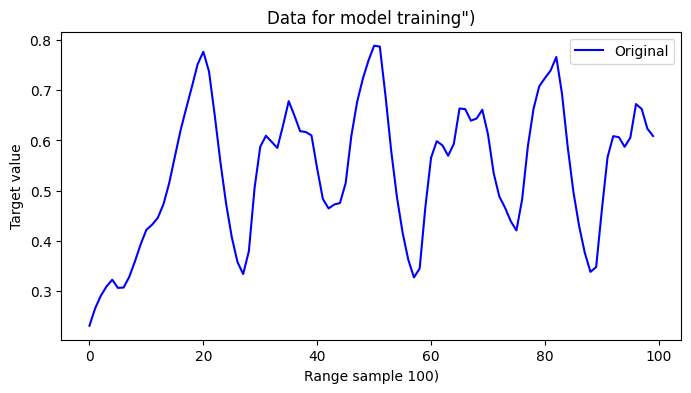

In [5]:
### Plot loaded TSs
X_list = [0]
y_list = [y]

# print(f'y_train_ts.shape = {y_train_ts.shape}')
# print(f'y_test_ts.shape = {y_test_ts.shape}')

print()
multi_plot_flat_ts(y_list, X_list=X_list,
    colors = ['blue'],
    labels = ['Original'],
    lines = ['solid'], legend_cols=1, 
    rcParams=(8, 4), #ylim=(0, 3.5),
    xlabel=f'Range sample 100)',
    title=f'Data for model training")'
    )
print()

In [6]:
### Run specific architectural + training param
#   These parameter values can be set from the test data

### Data params

samples = 100
split = 0.75
train_size = int(samples*split)     # Use the first train_size points for training
test_size = samples - train_size    # Use the next test_size points for testing

wind_size = 5
wind_step = 2
horizon = 1

noise = 0.1 # This is max absolute, in relation to value range (0, 1)

### Model params
rot = 'Rxyz' # Ry / Rxyz
n_layers = 3
n_latent = 3
n_extra = 2
n_epochs = 100 # 1000 # 2000
log_interv = 1
param_scaler = 0.1

### Derived params
n_trash = wind_size - n_latent
n_data = n_latent + n_trash
n_wires = n_latent + n_trash + n_extra

### Other (CASE_NAME) invariant params
diff_method = 'best'
interface = None # we will use default
level='gradient'
shuffle_interv = 0
cost_type = 'MSE'
cost_yscale = 'linear' # linear, log
shots = None # We use a state vector simulator

### Currently are not generated here, but QAE models should run 10 times with diff inits
#   The number of times the model should be run with different initial params
#   Each instance history and params should be saved and later used
n_inst = 1

### Random seed(s)
#   We may need to create different seeds for each model instance

seed = 2024

if seed == 0: 
    np.random.seed(rand_seed())
else:
    np.random.seed(seed)
inst_seeds = [int(n) for n in np.random.randint(0, high=9999, size=n_inst)]

In [7]:
### Libraries used in QAE development

# PennyLane imports
import pennylane as qml
from pennylane import numpy as np

In [8]:
### Create time series tensor data with optional noise (note that windows overlap by wind_step)
def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2):
    y_ts = ts_wind_make(ts_add_noise(y, noise), wind_size, wind_step)
    X_ts = np.array([i*wind_step for i in range(len(y_ts))])
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = np.tensor(X_train_ts, requires_grad=False)
    y_train_tens = np.tensor(y_train_ts, requires_grad=False)
    X_test_tens = np.tensor(X_test_ts, requires_grad=False)
    y_test_tens = np.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [9]:
### Our own gradient-friendly loss/cost function
#   Beware in PennyLane these MUST be very pure
#   to be differentiable (so not external / fancy functions)
def mse_cost_on_tensors(targets, predictions):
    cost = 0
    vals = 0
    for i in range(len(targets)):
        for w in range(len(targets[i])):
            cost = cost + (targets[i][w] - predictions[i][w]) ** 2
            vals += 1
    cost = cost / vals
    return cost

### The cost function generator
def cost_fun_gen_on_tensors(model, cost_fun):
    def _cost_fun(params, inputs, targets):
        nonlocal model, cost_fun
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

In [10]:
##### Prepare for training

### For reproducibility
np.random.seed(seed)

### Select one of the following optimisers built into PennyLane
# opt = qml.GradientDescentOptimizer(stepsize=0.5)
# opt = qml.RMSPropOptimizer(stepsize=0.1, decay=0.7, eps=1e-08)
# opt = qml.NesterovMomentumOptimizer(stepsize=0.5)
# opt = RCDOptimizer(h=0.1)
opt = qml.AdamOptimizer(stepsize=0.5)

## SWAP TEST

In [11]:
### Half QAE unified shape
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_layers: number of layers (repeats)
#   returns: shape
def half_qae_shape_unified(n_latent, n_trash, n_extra=0, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

In [12]:
def half_qae_unified(wires, n_latent, n_trash, n_layers=1, rot='Ry', dagger=False):
    latent_wires = wires[:n_latent]
    trash_wires  = wires[n_latent:n_latent+n_trash]
    data_wires   = latent_wires + trash_wires
    anz_wires    = data_wires

    def _sequence_encoder(wires, inputs):
        n_inputs = len(inputs)
        for w in wires:
            if w > n_inputs-1:
                qml.RY(0, wires=w)
            else:
                qml.RY(inputs[w], wires=w)

    def _entangler_shape(n_layers, n_wires, rot='Ry'):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return ()

    def _entangler(wires, weights, rot='Ry'):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=anz_wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=anz_wires)

    def _half_qae_unified(weights, inputs):
        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)
        shape = _entangler_shape(n_layers, len(anz_wires), rot=rot)
        w = weights.reshape(shape)
        if dagger:
            qml.adjoint(_entangler)(anz_wires, w, rot=rot)
            #return [qml.expval(qml.PauliZ(w)) for w in latent_wires + trash_wires]
        else:
            _entangler(anz_wires, w, rot=rot)
            #return [qml.expval(qml.PauliZ(w)) for w in trash_wires]

    return _half_qae_unified

In [13]:
##### Create a model

wires = list(range(n_latent + n_trash))

### Check the HALF QAE shape
shape = half_qae_shape_unified(n_latent, n_trash, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)
print(f'Half-QAE unified shape: {shape}, weights: {int(n_weights)}\n')
sample_params = np.random.uniform(high=param_scaler, size=shape, requires_grad=True)
sample_data = np.linspace(100, 200, n_latent + n_trash, requires_grad=False)

Half-QAE unified shape: (3, 5, 3), weights: 45



In [14]:
# Parameters
n_latent = 2
n_trash = 2
n_layers = 1
rot = 'Ry'
n_data = n_latent + n_trash
n_wires = n_data * 2 + 1  # input, output, control
input_wires = list(range(n_data))
output_wires = list(range(n_data, n_data*2))
control_wire = n_wires - 1

In [15]:
dev = qml.device("default.qubit", wires=n_wires)

In [16]:
encoder_block = half_qae_unified(input_wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=False)
decoder_block = half_qae_unified(output_wires, n_latent, n_trash, n_layers=n_layers, rot=rot, dagger=True)

In [17]:
@qml.qnode(dev)
def swap_test(vec, weights_enc, weights_dec):
    # Encode data on input_wires
    norm_vec = np.array(vec) / np.linalg.norm(vec)
    qml.MottonenStatePreparation(norm_vec, wires=input_wires)
    # ENCODER
    encoder_block(weights_enc, norm_vec)
    # DECODER (reconstructs on output_wires from latents)
    decoder_block(weights_dec, norm_vec)
    # SWAP test
    qml.Hadamard(wires=control_wire)
    for i in range(n_data):
        qml.CSWAP(wires=[control_wire, output_wires[i], input_wires[i]])
    qml.Hadamard(wires=control_wire)
    return qml.probs(wires=control_wire)

In [18]:
# Cost function (1 - fidelity)
def loss(vec, weights_enc, weights_dec):
    p0 = swap_test(vec, weights_enc, weights_dec)[0]
    fidelity = 2 * p0 - 1
    return 1 - fidelity


In [19]:
# Example data
t = np.linspace(0, 2*np.pi, 100)
series = np.sin(t)
window_size = 16
windows = [series[i:i+window_size] for i in range(len(series) - window_size)]

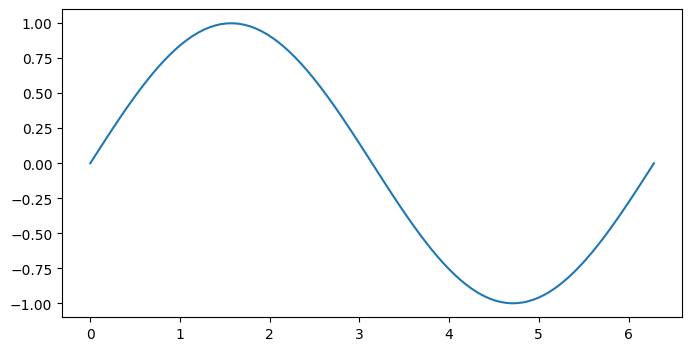

In [20]:
plt.plot(t, series, label='Original Series')

In [21]:
weight_scaler = 0.1 
shape = half_qae_shape_unified(n_latent, n_trash, n_extra=0, n_layers=n_layers, rot=rot)
weights_enc = np.random.uniform(high=np.pi, size=shape, requires_grad=True) * weight_scaler
weights_dec = np.random.uniform(high=np.pi, size=shape, requires_grad=True) * weight_scaler

Step 0: loss = 0.933946
Step 5: loss = 0.525465
Step 10: loss = 0.545746
Step 15: loss = 0.296847
Step 20: loss = 0.335986
Step 25: loss = 0.292927


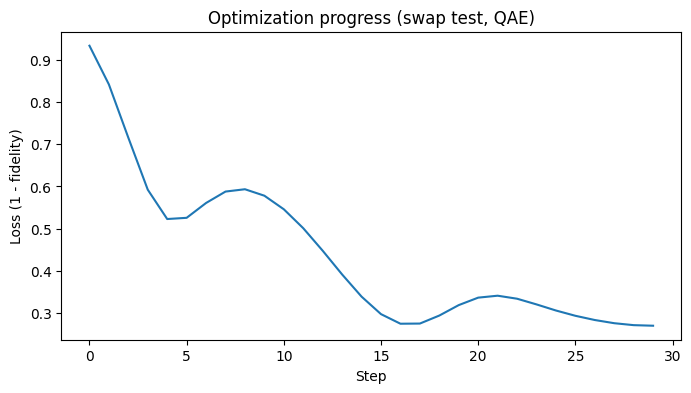

In [22]:
opt = qml.AdamOptimizer(stepsize=0.2)
steps = 30
losses = []

for i in range(steps):
    weights_enc, weights_dec = opt.step(
        lambda we, wd: qml.math.mean(qml.math.stack([loss(w, we, wd) for w in windows])),
        weights_enc, weights_dec
    )
    l = qml.math.mean(qml.math.stack([loss(w, weights_enc, weights_dec) for w in windows]))
    losses.append(l)
    if i % 5 == 0:
        print(f"Step {i}: loss = {l:.6f}")

# Cost function plot
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss (1 - fidelity)")
plt.title("Optimization progress (swap test, QAE)")
plt.show()

In [23]:
final_fidelity = 1 - float(losses[-1])
print(f"Final reconstruction fidelity: {final_fidelity:.6f}")

Final reconstruction fidelity: 0.730664


In [24]:
mean_fidelity = np.mean([1 - float(l) for l in losses])
print(f"Mean reconstruction fidelity: {mean_fidelity:.6f}")

Mean reconstruction fidelity: 0.561381


## MACKEY GLASS DATA 

In [25]:
# --- Prepare clean Mackey-Glass data ---
y_raw = mackey_glass(beta=beta, gamma=gamma, n=n, tau=tau, dt=dt, T=T)
y_raw = scale_values(y_raw, new_min=scale_low, new_max=scale_high)
y_clean = y_raw[2::3]
window_size = 16
windows_clean = [y_clean[i:i+window_size] for i in range(len(y_clean) - window_size)]

# --- Prepare noisy Mackey-Glass data ---
noise_level = 0.1
y_noisy = ts_add_noise(y_clean, noise_level)
windows_noisy = [y_noisy[i:i+window_size] for i in range(len(y_noisy) - window_size)]

# --- Training on clean data ---
shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_data)
weights_enc_clean = np.random.uniform(high=np.pi, size=shape, requires_grad=True) * weight_scaler
weights_dec_clean = np.random.uniform(high=np.pi, size=shape, requires_grad=True) * weight_scaler

opt = qml.AdamOptimizer(stepsize=0.2)
steps = 30
losses_clean = []

for i in range(steps):
    weights_enc_clean, weights_dec_clean = opt.step(
        lambda we, wd: qml.math.mean(qml.math.stack([loss(w, we, wd) for w in windows_clean])),
        weights_enc_clean, weights_dec_clean
    )
    l = qml.math.mean(qml.math.stack([loss(w, weights_enc_clean, weights_dec_clean) for w in windows_clean]))
    losses_clean.append(l)
    if i % 5 == 0:
        print(f"[Clean] Step {i}: loss = {l:.6f}")


# --- Fidelity comparison ---
fidelities_clean = [1 - float(loss(w, weights_enc_clean, weights_dec_clean)) for w in windows_clean]

print("Mean fidelity (clean-trained):", np.mean(fidelities_clean))


[Clean] Step 0: loss = 0.937790
[Clean] Step 5: loss = 0.299113
[Clean] Step 10: loss = 0.186118
[Clean] Step 15: loss = 0.169648
[Clean] Step 20: loss = 0.092437
[Clean] Step 25: loss = 0.099069
Mean fidelity (clean-trained): 0.9220982774262518


In [26]:
# --- Training on noisy data ---
weights_enc_noisy = np.random.uniform(high=np.pi, size=shape, requires_grad=True) * weight_scaler
weights_dec_noisy = np.random.uniform(high=np.pi, size=shape, requires_grad=True) * weight_scaler
losses_noisy = []

for i in range(steps):
    weights_enc_noisy, weights_dec_noisy = opt.step(
        lambda we, wd: qml.math.mean(qml.math.stack([loss(w, we, wd) for w in windows_noisy])),
        weights_enc_noisy, weights_dec_noisy
    )
    l = qml.math.mean(qml.math.stack([loss(w, weights_enc_noisy, weights_dec_noisy) for w in windows_noisy]))
    losses_noisy.append(l)
    if i % 5 == 0:
        print(f"[Noisy] Step {i}: loss = {l:.6f}")


fidelities_noisy = [1 - float(loss(w, weights_enc_noisy, weights_dec_noisy)) for w in windows_noisy]
print("Mean fidelity (noisy-trained):", np.mean(fidelities_noisy))



[Noisy] Step 0: loss = 0.936831
[Noisy] Step 5: loss = 0.703762
[Noisy] Step 10: loss = 0.175032
[Noisy] Step 15: loss = 0.212153
[Noisy] Step 20: loss = 0.242558
[Noisy] Step 25: loss = 0.083813
Mean fidelity (noisy-trained): 0.8820371445251054
